In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from networkx import from_numpy_matrix, degree_centrality, closeness_centrality, betweenness_centrality, subgraph_centrality

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, rank_int, node_strength, ave_control, modal_control

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 200 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

In [5]:
if parc_str == 'schaefer' or parc_str == 'glasser':
    exclude_str = 't1Exclude'
else:
    exclude_str = 'fsFinalExclude'

In [6]:
# output file prefix
run_hemi = ''
if run_hemi == 'ipsi':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_ipsi_'
elif run_hemi == 'contra':
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_contra_'
else:
    outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

In [7]:
# we want to calculate conn features including subcortex
# drop brainstem but retain subcortex.
if parc_str == 'lausanne':
    num_parcels = len(parcel_loc[parcel_loc != 2])

### Setup directory variables

In [8]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [9]:
storedir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store')
print(storedir)
if not os.path.exists(storedir): os.makedirs(storedir)

outputdir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/1_compute_node_features/store
/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline/1_compute_node_features/out


In [10]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


## Load data

In [11]:
# Load data
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', exclude_str+'_df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1100, 54)


In [12]:
# Missing data file for this subject only for schaefer 200
if parc_scale == 200:
    df.drop(labels = (112598, 5161), inplace=True)

In [13]:
# if run_ipsi == True and parc_str == 'schaefer' and parc_scale == 200:
#     num_parcels = int(num_parcels/2)
#     print(num_parcels)

In [14]:
# output dataframe
str_labels = ['str_' + str(i) for i in range(num_parcels)]
ac_labels = ['ac_' + str(i) for i in range(num_parcels)]
mc_labels = ['mc_' + str(i) for i in range(num_parcels)]
bc_labels = ['bc_' + str(i) for i in range(num_parcels)]
cc_labels = ['cc_' + str(i) for i in range(num_parcels)]
sgc_labels = ['sgc_' + str(i) for i in range(num_parcels)]

df_node = pd.DataFrame(index = df.index, columns = str_labels + ac_labels + mc_labels + bc_labels + cc_labels + sgc_labels)
print(df_node.shape)

(1099, 1200)


## Load in structural connectivity matrices

In [15]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [16]:
print(os.environ['CONN_STR'])

A = np.zeros((num_parcels, num_parcels, df.shape[0]))
for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['SC_NAME_TMP'].replace("scanid", str(index[1]))
    file_name = file_name.replace("bblid", str(index[0]))
    full_path = glob.glob(os.path.join(os.environ['SCDIR'], file_name))
    if i == 0: print(full_path)
    if len(full_path) > 0:
        mat_contents = sio.loadmat(full_path[0])
        a = mat_contents[os.environ['CONN_STR']]
        if parc_str == 'lausanne': # drop brainstem but retain subcortex.
            a = a[parcel_loc != 2,:]
            a = a[:,parcel_loc != 2]
        if run_hemi == 'intra' and parc_str == 'schaefer' and parc_scale == 200: # reting ipsilateral hemisphere (optional)
#             a = a[:num_parcels,:num_parcels]
            my_idx = int(num_parcels/2)
            a[:my_idx,my_idx:] = 0
            a[my_idx:,:my_idx] = 0
        if run_hemi == 'contra' and parc_str == 'schaefer' and parc_scale == 200: # reting ipsilateral hemisphere (optional)
            my_idx = int(num_parcels/2)
            a[:my_idx,:my_idx] = 0
            a[my_idx:,my_idx:] = 0
        A[:,:,i] = a
    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        A[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

connectivity
['/Volumes/work_ssd/research_data/PNC/processedData/diffusion/deterministic_20171118/81287/20100114x2738/tractography/connectivity/81287_20100114x2738_SchaeferPNC_200_dti_streamlineCount_connectivity.mat']
82051/*x2856/tractography/connectivity/82051_*x2856_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87804/*x3144/tractography/connectivity/87804_*x3144_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
91332/*x3362/tractography/connectivity/91332_*x3362_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87990/*x3676/tractography/connectivity/87990_*x3676_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
103737/*x3964/tractography/connectivity/103737_*x3964_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87470/*x4000/tractography/connectivity/87470_*x4000_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
104161/*x4104/tractography/connectivity/104161_*x4104_SchaeferPNC_200_dti_streamlin

In [17]:
np.sum(subj_filt)

19

In [18]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1080, 1200)


<AxesSubplot:>

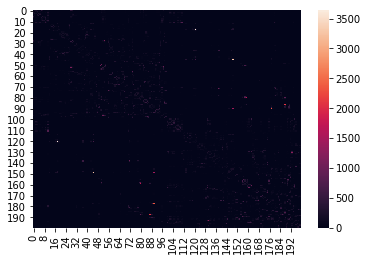

In [19]:
sns.heatmap(np.nanmean(A,2))

### Check if any subjects have disconnected nodes in A matrix

In [20]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [21]:
for i in range(A.shape[2]):
    if np.any(np.sum(A[:,:,i], axis = 1) == 0):
        subj_filt[i] = True

In [22]:
np.sum(subj_filt)

12

In [23]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1068, 1200)


In [24]:
np.sum(df['averageManualRating'] == 2)

924

In [25]:
np.sum(df['dti64QAManualScore'] == 2)

655

### Get streamline count and network density

In [26]:
A_c = np.zeros((A.shape[2],))
A_d = np.zeros((A.shape[2],))
for i in range(A.shape[2]):
    A_c[i] = np.sum(np.triu(A[:,:,i]))
    A_d[i] = np.count_nonzero(np.triu(A[:,:,i]))/((A[:,:,i].shape[0]**2-A[:,:,i].shape[0])/2)
df.loc[:,'streamline_count'] = A_c
df.loc[:,'network_density'] = A_d

### Compute node metrics

In [27]:
# fc stored as 3d matrix, subjects of 3rd dim
S = np.zeros((df.shape[0], num_parcels))
AC = np.zeros((df.shape[0], num_parcels))
MC = np.zeros((df.shape[0], num_parcels))
BC = np.zeros((df.shape[0], num_parcels))
CC = np.zeros((df.shape[0], num_parcels))
SGC = np.zeros((df.shape[0], num_parcels))

# for (i, (index, row)) in enumerate(df.iterrows()):
for i in tqdm(np.arange(df.shape[0])):
    S[i,:] = node_strength(A[:,:,i])
    AC[i,:] = ave_control(A[:,:,i])
    MC[i,:] = modal_control(A[:,:,i])
    G = from_numpy_matrix(A[:,:,i])
    BC[i,:] = np.array(list(betweenness_centrality(G, normalized=False).values()))
    CC[i,:] = np.array(list(closeness_centrality(G).values()))
    SGC[i,:] = np.array(list(subgraph_centrality(G).values()))
    
df_node.loc[:,str_labels] = S
df_node.loc[:,ac_labels] = AC
df_node.loc[:,mc_labels] = MC
df_node.loc[:,bc_labels] = BC
df_node.loc[:,cc_labels] = CC
df_node.loc[:,sgc_labels] = SGC

100%|██████████| 1068/1068 [05:56<00:00,  3.00it/s]


## Recalculate average control at different C params

In [28]:
c_params = np.array([10, 100, 1000, 10000])
c_params

array([   10,   100,  1000, 10000])

In [29]:
# output dataframe
df_node_ac_overc = pd.DataFrame(index = df.index)

for c in c_params:
    print(c)
    ac_labels_new = ['ac_c' + str(c) + '_' + str(i) for i in range(num_parcels)]
    df_node_ac_temp = pd.DataFrame(index = df.index, columns = ac_labels_new)
    
    # fc stored as 3d matrix, subjects of 3rd dim
    AC = np.zeros((df.shape[0], num_parcels))
    for i in tqdm(np.arange(df.shape[0])):
        AC[i,:] = ave_control(A[:,:,i], c = c)

    df_node_ac_temp.loc[:,ac_labels_new] = AC
    df_node_ac_overc = pd.concat((df_node_ac_overc, df_node_ac_temp), axis = 1)

  0%|          | 4/1068 [00:00<00:27, 39.04it/s]

10


  0%|          | 5/1068 [00:00<00:25, 42.07it/s]

100


  0%|          | 5/1068 [00:00<00:25, 42.45it/s]

1000


  0%|          | 4/1068 [00:00<00:26, 39.41it/s]

10000


100%|██████████| 1068/1068 [00:25<00:00, 41.31it/s]


## Scale average controllability to test for differences in initial conditions

In [30]:
df_node_ac_i2 = df_node.loc[:,ac_labels] * (2**2)
df_node_ac_overc_i2 = df_node_ac_overc * (2**2)

# Save out raw data

In [31]:
print(df_node.isna().any().any())
print(df_node_ac_overc.isna().any().any())
print(df_node_ac_i2.isna().any().any())
print(df_node_ac_overc_i2.isna().any().any())

False
False
False
False


In [32]:
np.save(os.path.join(storedir, outfile_prefix+'A'), A)

df_node.to_csv(os.path.join(storedir, outfile_prefix+'df_node.csv'))
df_node_ac_overc.to_csv(os.path.join(storedir, outfile_prefix+'df_node_ac_overc.csv'))
df_node_ac_i2.to_csv(os.path.join(storedir, outfile_prefix+'df_node_ac_i2.csv'))
df_node_ac_overc_i2.to_csv(os.path.join(storedir, outfile_prefix+'df_node_ac_overc_i2.csv'))

df.to_csv(os.path.join(storedir, outfile_prefix+'df.csv'))

# Export for prediction

## Normalize

### Covariates

In [33]:
covs = ['ageAtScan1', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS', 'network_density', 'streamline_count']

In [34]:
rank_r = np.zeros(len(covs),)

for i, cov in enumerate(covs):
    x = rank_int(df.loc[:,cov])
    rank_r[i] = sp.stats.spearmanr(df.loc[:,cov],x)[0]
    df.loc[:,cov] = x

print(np.sum(rank_r < 0.99))

0


### Node features

In [35]:
rank_r = np.zeros(df_node.shape[1],)

for i in tqdm(np.arange(df_node.shape[1])):
    col = df_node.iloc[:,i].name
    x = rank_int(df_node.loc[:,col])
    rank_r[i] = sp.stats.spearmanr(df_node.loc[:,col],x)[0]
    df_node.loc[:,col] = x

print(np.sum(rank_r < .99))

100%|██████████| 1200/1200 [02:35<00:00,  7.73it/s]

0


In [36]:
rank_r = np.zeros(df_node_ac_i2.shape[1],)

for i in tqdm(np.arange(df_node_ac_i2.shape[1])):
    col = df_node_ac_i2.iloc[:,i].name
    x = rank_int(df_node_ac_i2.loc[:,col])
    rank_r[i] = sp.stats.spearmanr(df_node_ac_i2.loc[:,col],x)[0]
    df_node_ac_i2.loc[:,col] = x

print(np.sum(rank_r < .99))

100%|██████████| 200/200 [00:24<00:00,  8.25it/s]

0


In [37]:
rank_r = np.zeros(df_node_ac_overc.shape[1],)

for i in tqdm(np.arange(df_node_ac_overc.shape[1])):
    col = df_node_ac_overc.iloc[:,i].name
    x = rank_int(df_node_ac_overc.loc[:,col])
    rank_r[i] = sp.stats.spearmanr(df_node_ac_overc.loc[:,col],x)[0]
    df_node_ac_overc.loc[:,col] = x

print(np.sum(rank_r < .99))

100%|██████████| 800/800 [01:35<00:00,  8.37it/s]

0


In [38]:
rank_r = np.zeros(df_node_ac_overc_i2.shape[1],)

for i in tqdm(np.arange(df_node_ac_overc_i2.shape[1])):
    col = df_node_ac_overc_i2.iloc[:,i].name
    x = rank_int(df_node_ac_overc_i2.loc[:,col])
    rank_r[i] = sp.stats.spearmanr(df_node_ac_overc_i2.loc[:,col],x)[0]
    df_node_ac_overc_i2.loc[:,col] = x

print(np.sum(rank_r < .99))

100%|██████████| 800/800 [01:36<00:00,  8.29it/s]

0


### Psychosis

In [39]:
covs = ['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
print(phenos)

df_node.to_csv(os.path.join(outputdir, outfile_prefix+'X.csv'))
df_node_ac_overc.to_csv(os.path.join(outputdir, outfile_prefix+'X_ac_c.csv'))
df_node_ac_i2.to_csv(os.path.join(outputdir, outfile_prefix+'X_ac_i2.csv'))
df_node_ac_overc_i2.to_csv(os.path.join(outputdir, outfile_prefix+'X_ac_c_i2.csv'))

df.loc[:,phenos].to_csv(os.path.join(outputdir, outfile_prefix+'y.csv'))
df.loc[:,covs].to_csv(os.path.join(outputdir, outfile_prefix+'c.csv'))

covs = ['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS', 'streamline_count']
df.loc[:,covs].to_csv(os.path.join(outputdir, outfile_prefix+'c_sc.csv'))

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']
